In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 15})

## Czyszczenie danych

In [3]:
def finder(phrase):
    return lambda product_name: str(product_name).find(phrase)

df_org = pd.read_excel('shumee_mckinsey.xlsx', engine='openpyxl')
df = df_org[df_org['ID zamówienia'].notna()]  # usunięcie wpisów gdzie ID zamówienia == NaN
df = df[df['Nazwa produktu'] != 'Przesyłka pobraniowa']
df = df[df['Nazwa produktu'].map(finder("Kod rabatowy")) == -1]  # usuniecie kodow rabatowych
df = df[df['Miasto'] != 'test']
df = df[df['Miasto'] != 'Test']
df = df[df['Miasto'] != 'TEST']
df = df[df['Miasto'] != 'ssss']
df = df[df['Miasto'] != 'asd']
df = df[df['Miasto'] != 'asdasd']
df = df[df['Miasto'] != 'dsss']
df = df[df['Nazwa produktu'].map(finder("TESTOWY PRODUKT")) == -1]
df = df[df['Nazwa produktu'].map(finder("PRODUKT TESTOWY")) == -1]
df = df[df['Cena'] >= 0]  # usuniecie kodow rabatowych
# akceptuję produkty z ceną 0 zł, ponieważ są to produkty zamówione osobiście lub też telefonicznie

## Definiuję użyteczne funkcje

In [4]:
first_day = df["Data"].dt.date.min()
last_day = df["Data"].dt.date.max()
dti_days = pd.date_range(start=first_day, end=last_day, freq="D")

def plot_seasonality(name, season):
    """name: nazwa produktu
       season: ["quarter", "month", "week", "hour", "total"]. "Total" oznacza plot od początku do końca sprzedaży
       """
    
    if season == "quarter":
        df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.quarter)
        df1prod = df1prod["Ilość"].sum().reindex(range(1,5), fill_value = 0)
        plt.bar(range(4), df1prod, tick_label = ["Zima", "Wiosna", "Lato", "Jesień"])
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Kwartalna sprzedaż {name}")

    elif season == "month":
        df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.month)
        df1prod = df1prod["Ilość"].sum().reindex(range(1,13), fill_value = 0)
        plt.bar(range(12), df1prod, tick_label = "Sty Lut Mar Kwi Maj Cze Lip Sie Wrz Paz Lis Gru".split(" "))
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Miesięczna sprzedaż {name}")
        
    elif season == "week":
        df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.weekday)
        df1prod = df1prod["Ilość"].sum().reindex(range(0,7), fill_value = 0)
        plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Tygodniowa sprzedaż {name}")
        
    elif season =="hour":
        df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.hour)
        df1prod = df1prod["Ilość"].sum().reindex(range(0,7), fill_value = 0)
        #plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
        df1prod.plot(marker="o")
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.xlabel("Godzina")
        plt.title(f"Godzinna sprzedaż {name}")
        
    elif "total":
        df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.date)
        df1prod = df1prod["Ilość"].sum().reindex(dti_days, fill_value = 0)
        df1prod.plot()
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Sprzedaż {name}")

## Tworzę DataFrame, w którym trzymam sezonowość różnych produktów

In [7]:
# product_names = df["Nazwa produktu"].unique()
product_names = df.groupby("Nazwa produktu")["Ilość"].sum()
product_names = product_names[product_names > 100].index

var_day = []
var_month = []
var_quarter = []
var_hour = []
var_week = []
total_sells = []

for i, name in enumerate(product_names):
    if (i+1) % 5000 == 0:
        print("Przetworzyłem {i+1} nazw (z {len(products_names)}")
        
    total_sells.append(df[df["Nazwa produktu"]==name]["Ilość"].sum())
    
    # Kwartał
    df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.quarter)
    df1prod = df1prod["Ilość"].sum().reindex(range(1,5), fill_value = 0)
    var_quarter.append(np.var(df1prod))
    
    # Miesiąc
    df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.month)
    df1prod = df1prod["Ilość"].sum().reindex(range(1,13), fill_value = 0)
    var_month.append(np.var(df1prod))
    
    # Dzień tygodnia
    df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.weekday)
    df1prod = df1prod["Ilość"].sum().reindex(range(0,7), fill_value = 0)
    var_week.append(np.var(df1prod))
    
    # Godzina
    df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.hour)
    df1prod = df1prod["Ilość"].sum().reindex(range(0,25), fill_value = 0)
    var_hour.append(np.var(df1prod))

In [8]:
seasonality = pd.DataFrame(data={
                                "Suma sprzedaży" : total_sells,
                                "Kwartał" : var_quarter,
                                "Miesiąc" : var_month,
                                "Dzień tyg." : var_week,
                                "Godzina" : var_hour},
                           index = product_names)
                            
seasonality.head()

,Suma sprzedaży,Kwartał,Miesiąc,Dzień tyg.,Godzina
Nazwa produktu,,,,,
Atlantic - 2 SZT. SLIPY MĘSKIE BASIC,216.0,8748.00,3564.000000,5712.979592,1791.5904
Atlantic - 2 SZT. SLIPY MĘSKIE SIGN,108.0,2187.00,891.000000,1428.244898,447.8976
Atlantic - PODKOSZULEK DAMSKI BASIC,108.0,2187.00,891.000000,1428.244898,447.8976
Automatyczny system nawadniania ze zraszaczem i wł,188.0,2238.50,370.555556,132.693878,39.0496
Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka,210.0,7756.25,3197.250000,5105.142857,1611.1200


## Jakie przedmioty sprzedawały się najczęściej?

In [5]:
products_sells = df.groupby("Nazwa produktu")["Ilość"].sum()
products_sells = products_sells.sort_values(ascending=False)
products_sells.head(20)

Nazwa produktu
Wypukłe lustro drogowe, 30 cm, czarne                                                                     479.0
CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi                                                               444.0
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                                        412.0
PEPCO - Koc polarowy 130x160cm                                                                            358.0
Lampa sufitowa, plafon, białe i bezbarwne listki 3                                                        355.0
Lampa stroboskopowa do ustawiania zapłonu                                                                 303.0
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm 14283                                                        281.0
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    275.0
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm                                             

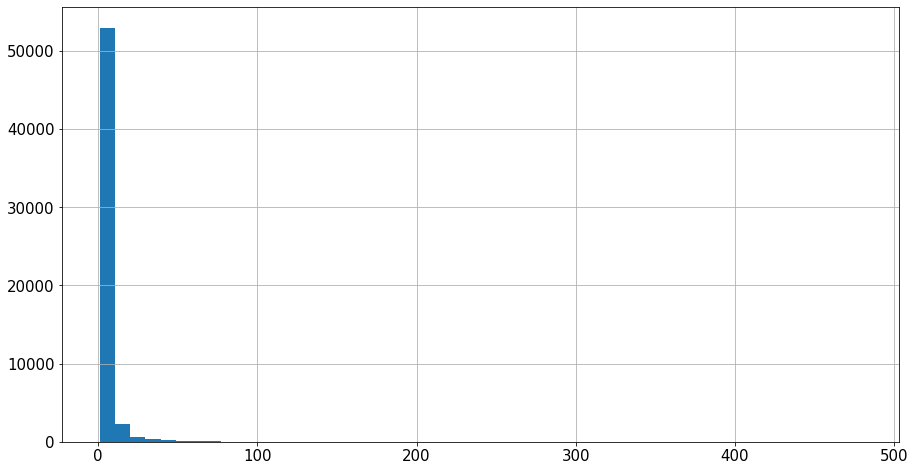

In [6]:
products_sells.hist(bins=50)
plt.show()

In [69]:
print(f"Produtków sprzedanych w liczbie mniejszej niż 10 jest {(products_sells < 10).sum()}")
print(f"To aż {100*(products_sells < 10).sum()/products_sells.shape[0]:.0f}% wszystkich produktów!")

Produtków sprzedanych w liczbie mniejszej niż 10 jest 52383
To aż 92% wszystkich produktów


Zatem konieczne jest pogrupowanie produktów

## Przyjrzyjmy się sprzedaży produktów, których sprzedano najwięcej sztuk

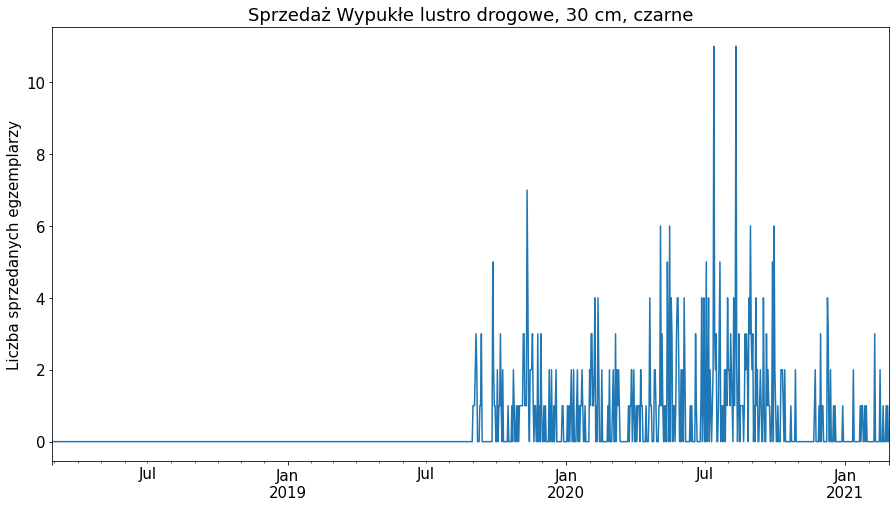

In [180]:
name = "Wypukłe lustro drogowe, 30 cm, czarne"
plot_seasonality(name = name, season = "total")

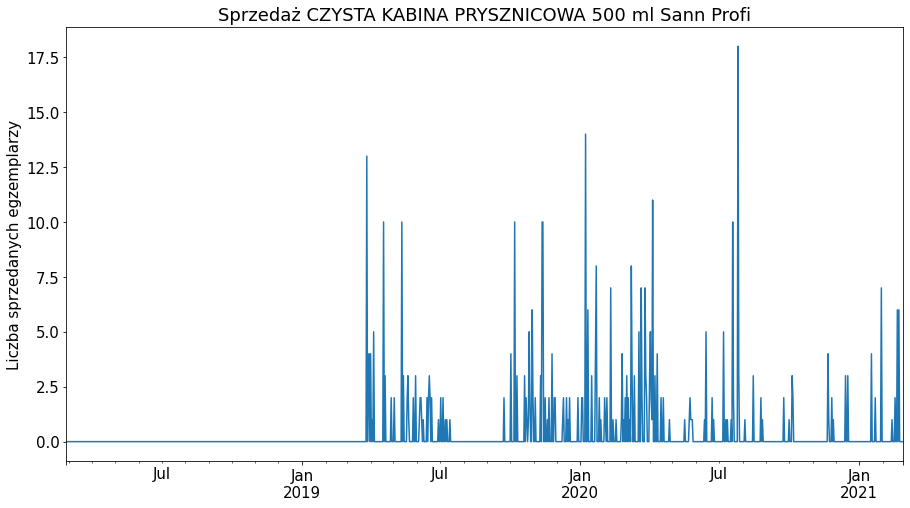

In [158]:
name = "CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi"
plot_seasonality(name = name, season = "total")

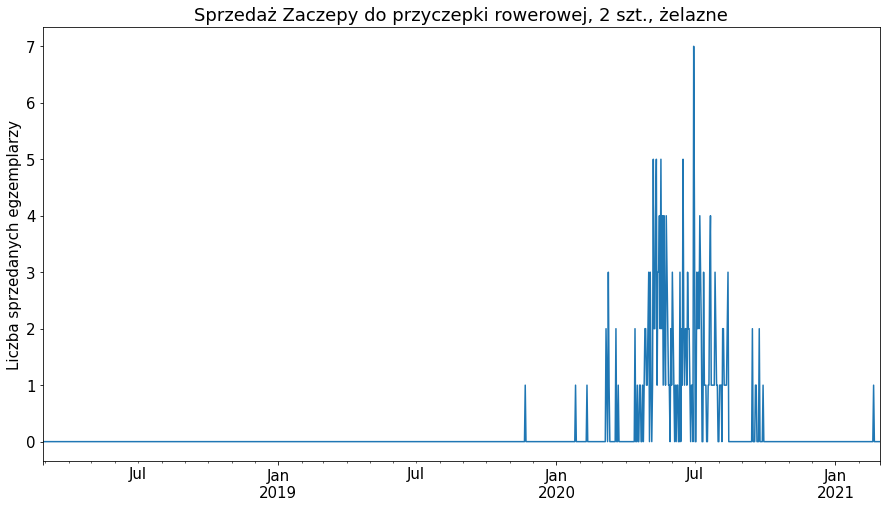

In [159]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "total")

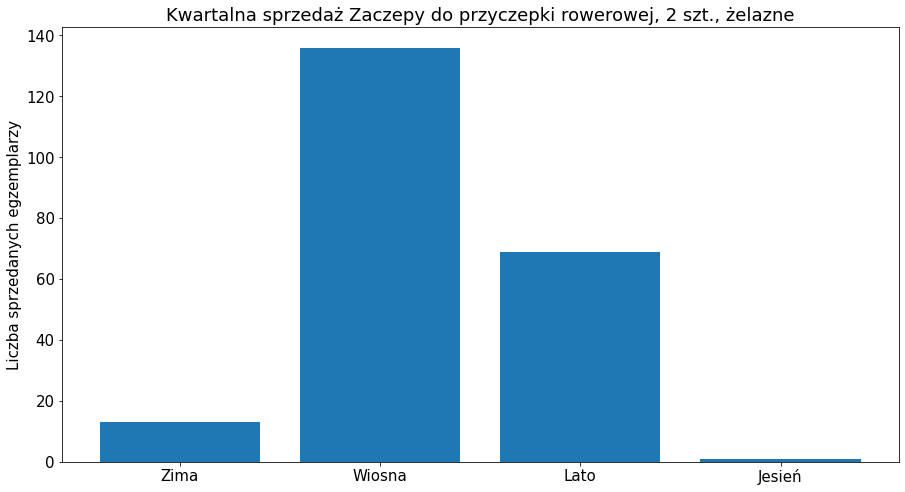

In [213]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "quarter")

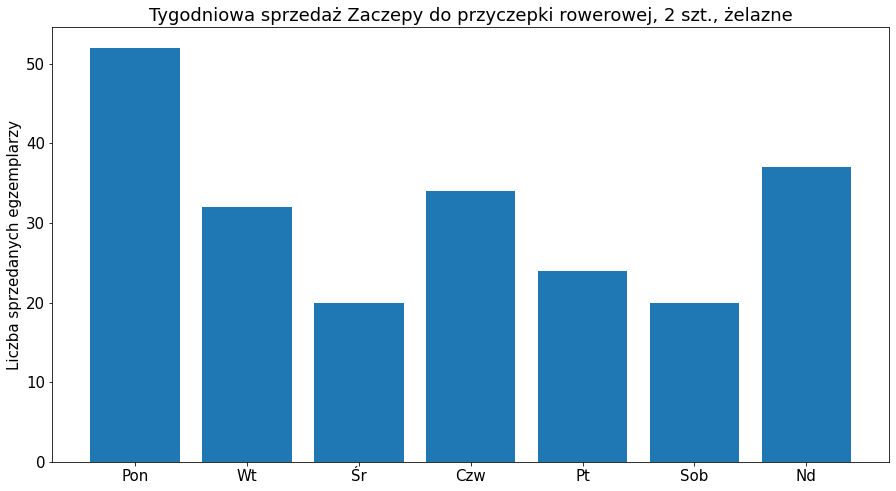

In [214]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "week")

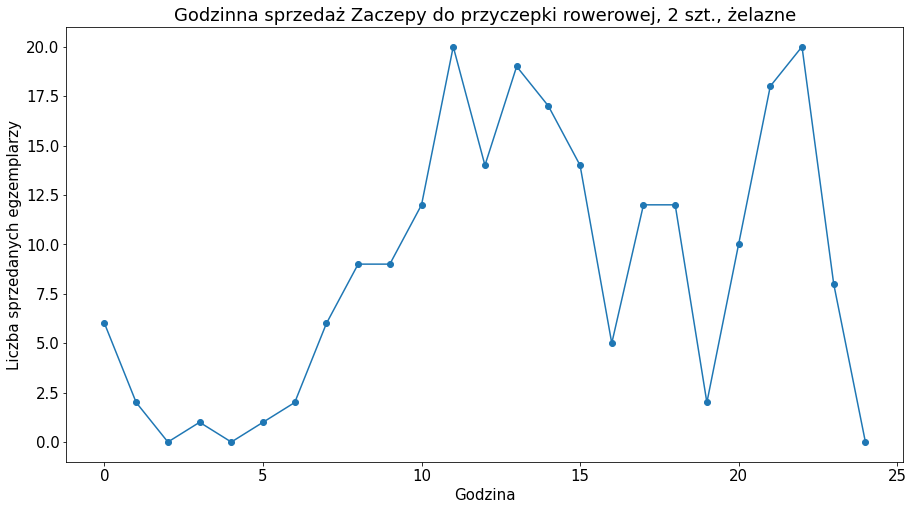

In [215]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "hour")

In [9]:
seasonality.idxmax()

Suma sprzedaży                Wypukłe lustro drogowe, 30 cm, czarne
Kwartał                              PEPCO - Koc polarowy 130x160cm
Miesiąc           Shumee Kommode Geräumiger Schrank 5 Schubladen...
Dzień tyg.        Shot na kaca ZOBRIUS Naturalny Norweski drink ...
Godzina           Shot na kaca ZOBRIUS Naturalny Norweski drink ...
dtype: object

In [219]:
print("Największa sezonowość kwartalna:")
seasonality["Kwartał"].sort_values(ascending=False)

Największa sezonowość kwartalna:


Nazwa produktu
PEPCO - Koc polarowy 130x160cm                                                                            14895.2500
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    13635.1875
Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy            10800.0000
Atlantic - 2 SZT. SLIPY MĘSKIE BASIC                                                                       8748.0000
Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka                     7756.2500
                                                                                                             ...    
Elastyczny pokrowiec na kanapę, z dżerseju, szary                                                            36.6875
Elastyczny pokrowiec na fotel, z dżerseju, beżowy                                                            28.6875
Ceramiczna umywalka Czarna okrągła               

In [225]:
print("Największa sezonowość miesięczna:")
seasonality["Miesiąc"].sort_values(ascending=False)

Największa sezonowość miesięczna:


Nazwa produktu
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    4706.909722
PEPCO - Koc polarowy 130x160cm                                                                            4633.138889
Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy            4016.666667
Atlantic - 2 SZT. SLIPY MĘSKIE BASIC                                                                      3564.000000
Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka                    3197.250000
                                                                                                             ...     
Elastyczny pokrowiec na sofę, z dżerseju, beżowy                                                            15.354167
Fotel tapicerowany tkaniną, jasnoszary                                                                      15.083333
Ceramiczna umywalka Czarna okrągła       

In [232]:
print("Największa sezonowość tygodniowa:")
seasonality["Dzień tyg."].sort_values(ascending=False)[:10]

Największa sezonowość tygodniowa:


Nazwa produktu
Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy    6395.918367
Atlantic - 2 SZT. SLIPY MĘSKIE BASIC                                                              5712.979592
Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka            5105.142857
DRITTO zestaw mebli z szarego technorattanu                                                       2069.387755
Atlantic - 2 SZT. SLIPY MĘSKIE SIGN                                                               1428.244898
Atlantic - PODKOSZULEK DAMSKI BASIC                                                               1428.244898
Mleko BOX 12 sztuk + 12 kartonów GRATIS MU! 3,2% 1L UHT Wart-Milk - 2.24 zł sztuka                1428.244898
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm 14283                                                1216.693878
PIŁKA BAS. R.60 -1 SZT.[PAKOWANE 100SZT]                                                          1193.14

In [231]:
print("Największa sezonowość godzinna:")
seasonality["Godzina"].sort_values(ascending=False)[:10]

Największa sezonowość godzinna:


Nazwa produktu
Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy    2027.8400
Atlantic - 2 SZT. SLIPY MĘSKIE BASIC                                                              1791.5904
Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka            1611.1200
DRITTO zestaw mebli z szarego technorattanu                                                        648.9600
Atlantic - 2 SZT. SLIPY MĘSKIE SIGN                                                                447.8976
Atlantic - PODKOSZULEK DAMSKI BASIC                                                                447.8976
Mleko BOX 12 sztuk + 12 kartonów GRATIS MU! 3,2% 1L UHT Wart-Milk - 2.24 zł sztuka                 447.8976
PEPCO - Koc polarowy 130x160cm                                                                     407.7376
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm                                                       390.6656
PIŁKA BAS. R.

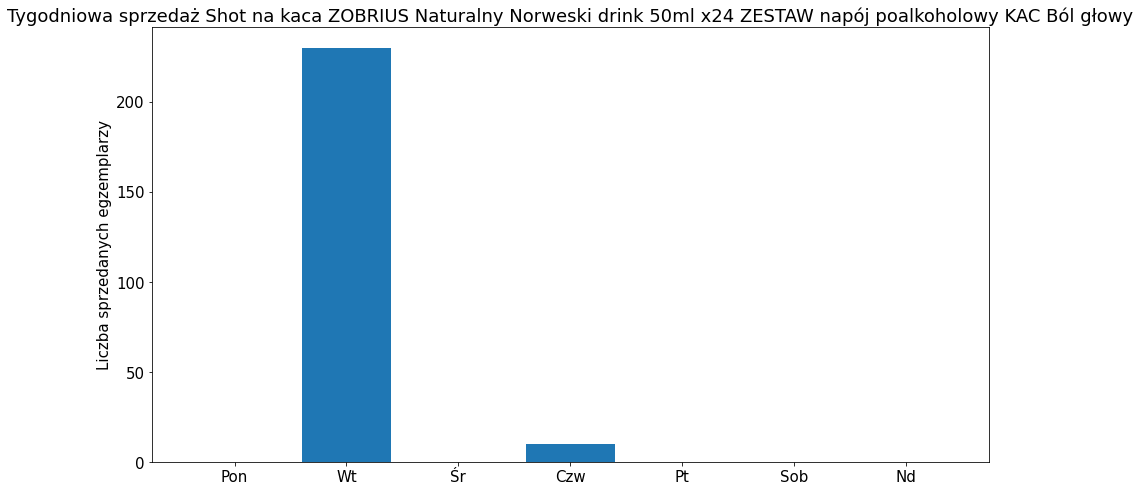

In [240]:
name = "Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy"
plot_seasonality(name = name, season = "week")

In [153]:
name = "Shot na kaca ZOBRIUS Naturalny Norweski drink 50ml x24 ZESTAW napój poalkoholowy KAC Ból głowy"

In [126]:
df[df["Nazwa produktu"]==name]

,ID zamówienia,Data,Źródło,Kraj,Miasto,Kod Pocztowy,Nazwa produktu,SKU,EAN,Ilość,Cena,Waluta,Koszt dostawy,Forma dostawy
33611,225676404,2020-12-01,Osobiście/tel.,PL,Łódź,90-006,Shot na kaca ZOBRIUS Naturalny Norweski drink ...,SH709005z,7090050070057,230.0,0.0,PLN,0.0,NaN
36061,223190016,2020-11-26,Osobiście/tel.,PL,Łódź,90-006,Shot na kaca ZOBRIUS Naturalny Norweski drink ...,SH709005z,7090050070057,10.0,0.0,PLN,0.0,NaN


In [117]:
from datetime import date

Suma sprzedaży      358.000000
Kwartał           14895.250000
Miesiąc            4633.138889
Dzień tyg.          774.693878
Godzina             407.737600
Name: PEPCO - Koc polarowy 130x160cm, dtype: float64


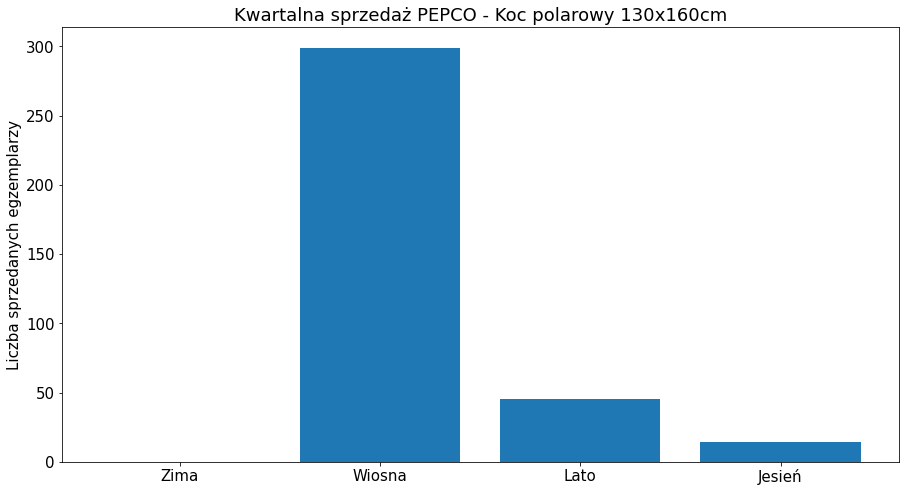

In [223]:
name = "PEPCO - Koc polarowy 130x160cm"
plot_seasonality(name = name, season = "quarter")
print(seasonality.loc[name])

In [130]:
date(2021, 4,9).dt.quarter()

AttributeError: 'datetime.date' object has no attribute 'dt'

Suma sprzedaży    105.000000
Kwartał            17.187500
Miesiąc            15.354167
Dzień tyg.         76.000000
Godzina            15.600000
Name: Elastyczny pokrowiec na sofę, z dżerseju, beżowy, dtype: float64


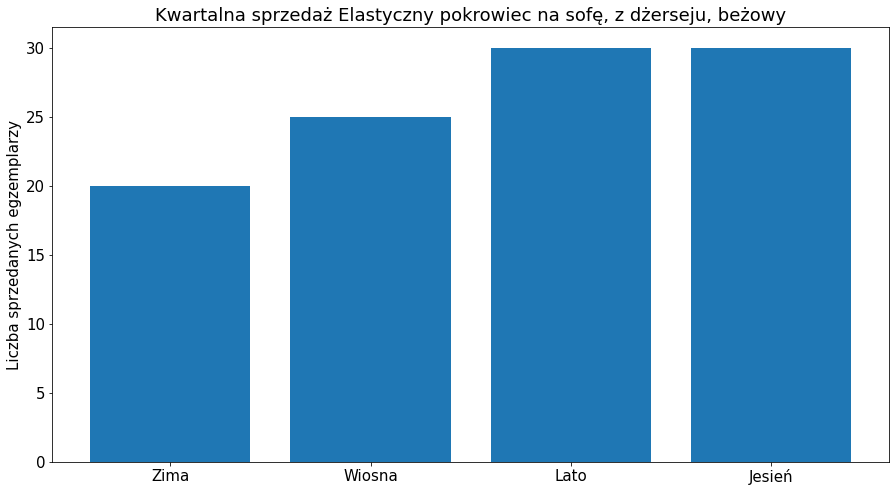

In [222]:
name="Elastyczny pokrowiec na sofę, z dżerseju, beżowy"
plot_seasonality(name = name, season = "quarter")
print(seasonality.loc[name])

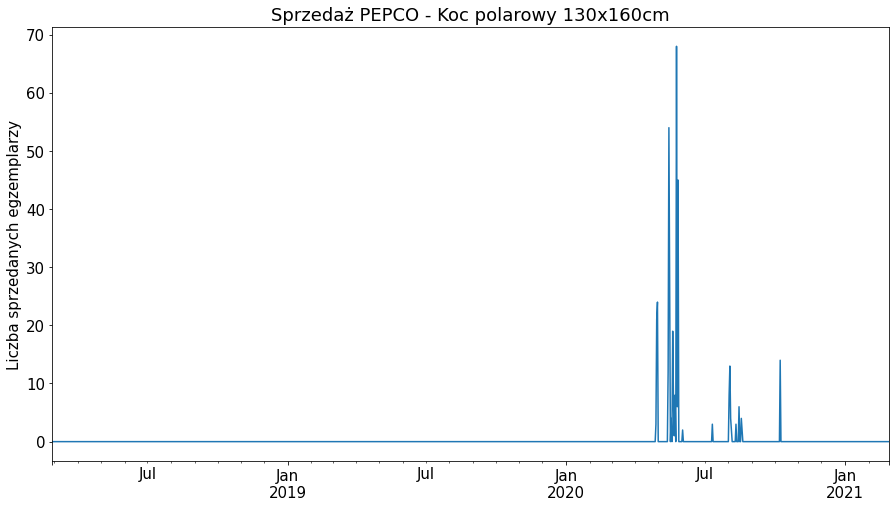

In [196]:
name = "PEPCO - Koc polarowy 130x160cm"
plot_seasonality(name = name, season = "total")

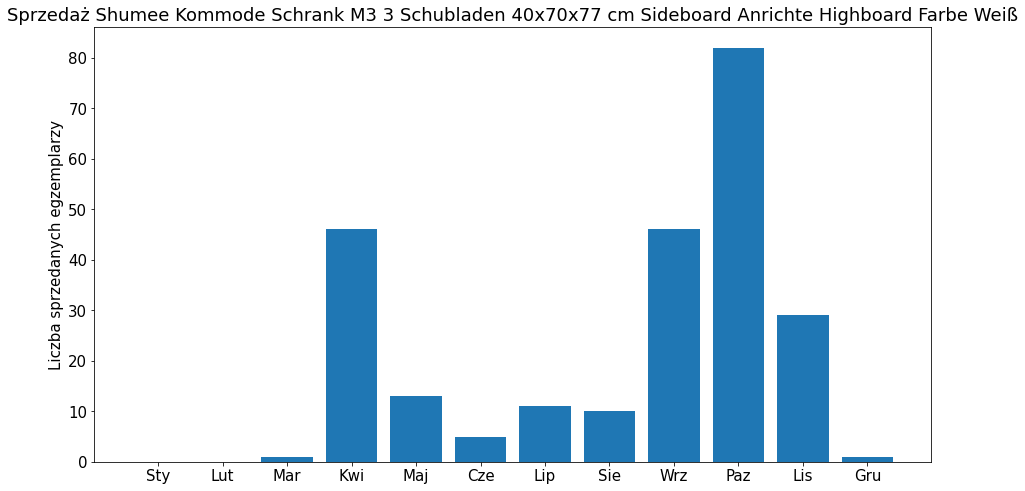

In [164]:
name = "Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß"
plot_seasonality(name = name, season = "month")

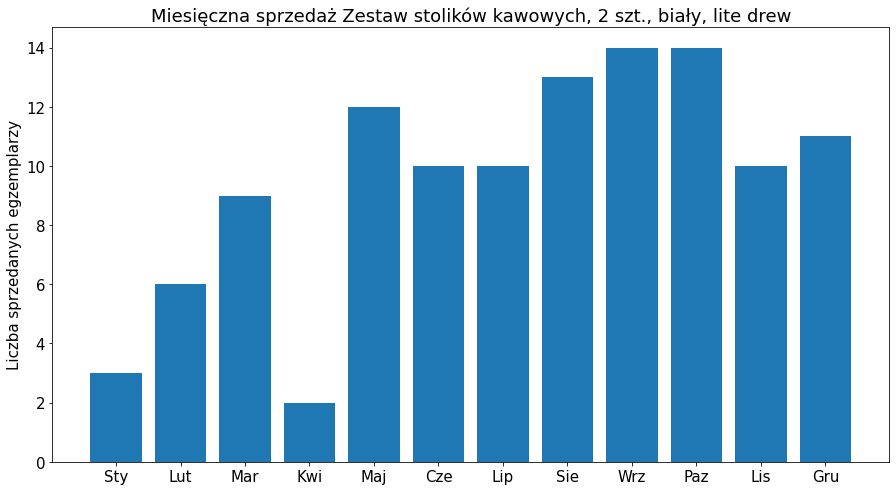

In [226]:
name="Zestaw stolików kawowych, 2 szt., biały, lite drew"
plot_seasonality(name = name, season = "month")

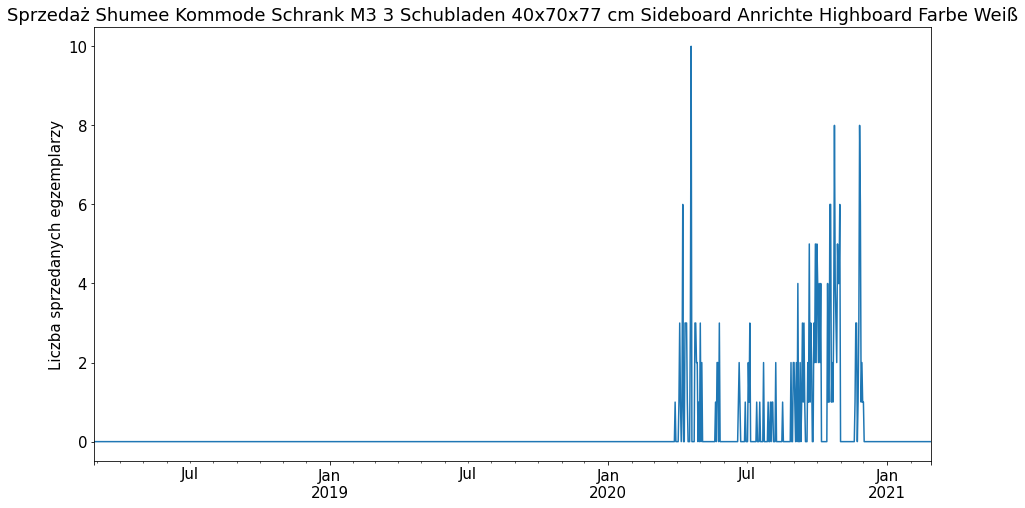

In [166]:
name = "Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß"
plot_seasonality(name = name, season = "total")

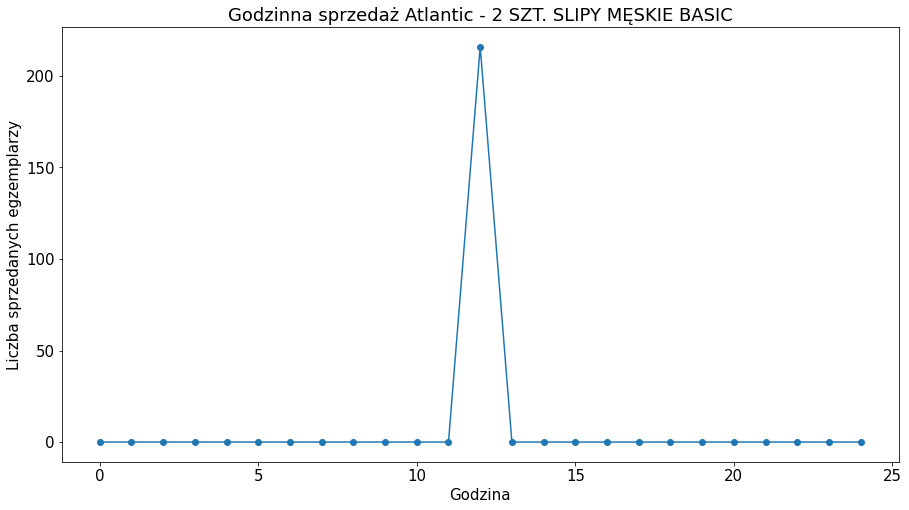

In [210]:
name = "Atlantic - 2 SZT. SLIPY MĘSKIE BASIC"
plot_seasonality(name=name, season="hour")

In [183]:
df.groupby(df["Data"].dt.hour)["ID zamówienia"].nunique().to_frame()

,ID zamówienia
Data,
0,3190
1,1151
2,589
3,398
4,326
5,486
6,2207
7,2944
8,5326


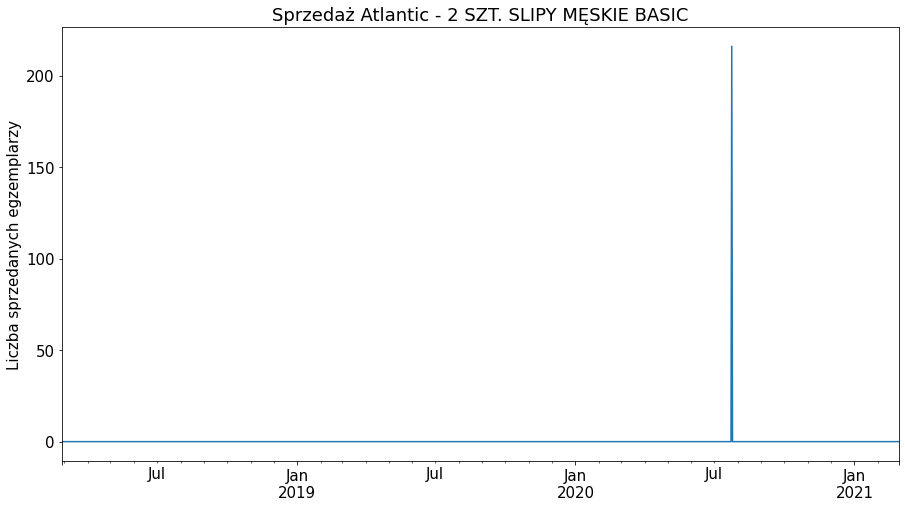

In [211]:
name = "Atlantic - 2 SZT. SLIPY MĘSKIE BASIC"
plot_seasonality(name=name, season="total")

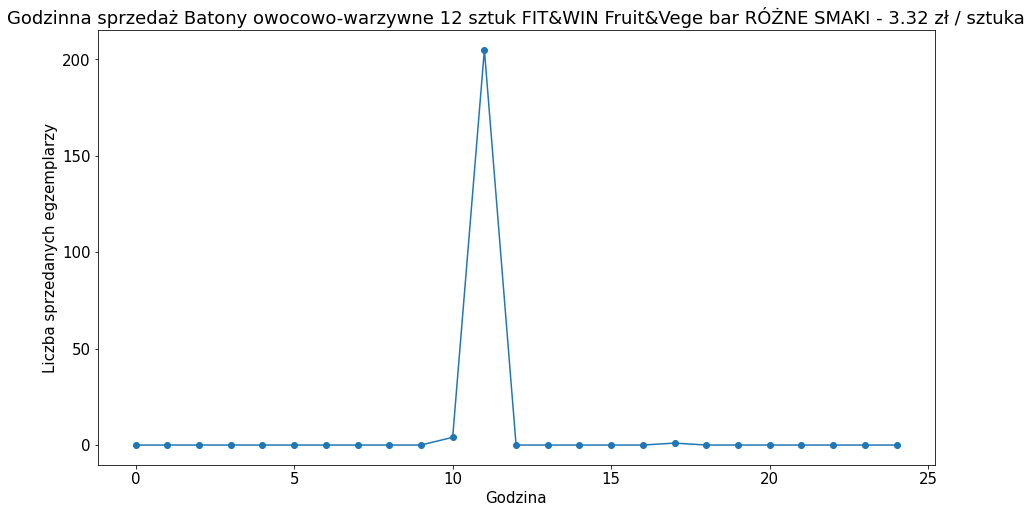

In [209]:
name = "Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka"
plot_seasonality(name=name, season="hour")

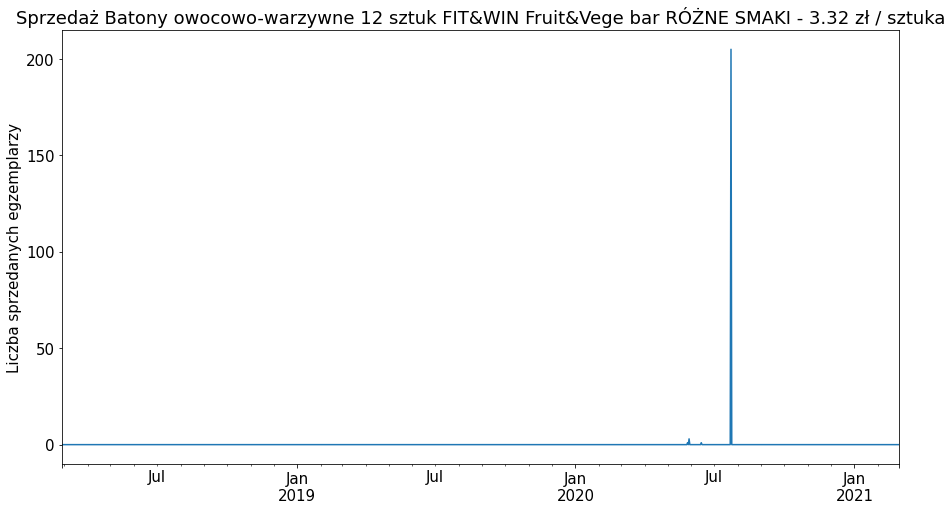

In [230]:
name = "Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka"
plot_seasonality(name=name, season="total")

In [200]:
df[df["Nazwa produktu"]==name]

,ID zamówienia,Data,Źródło,Kraj,Miasto,Kod Pocztowy,Nazwa produktu,SKU,EAN,Ilość,Cena,Waluta,Koszt dostawy,Forma dostawy


In [184]:
df.head()

,ID zamówienia,Data,Źródło,Kraj,Miasto,Kod Pocztowy,Nazwa produktu,SKU,EAN,Ilość,Cena,Waluta,Koszt dostawy,Forma dostawy
0,248342200,2021-01-31 23:43:39,Osobiście/tel.,CZ,Praha 4,14900,"shumee Strečový potah na pohovku antracitový, ...",131084,NaN,1.0,1163.00,CZK,0.0,DPD
1,248342190,2021-01-31 23:43:38,Osobiście/tel.,CZ,Nová Paka,50901,shumee Sada konferenčních stolků 2 ks masivní ...,244731,NaN,1.0,2783.00,CZK,0.0,DPD
2,248342194,2021-01-31 23:43:38,Osobiście/tel.,CZ,Pardubice,53002,shumee Toaleta pro psy s nádobou a umělou tráv...,170766,NaN,1.0,2591.00,CZK,0.0,DPD
3,248342187,2021-01-31 23:43:37,Osobiście/tel.,CZ,Hranice,75301,KLAUSBERG KB-7433 MILOVÁ SADA PRO PEPPER A SALT,5902666614339,NaN,2.0,383.00,CZK,0.0,DPD
4,248340112,2021-01-31 23:28:41,reedshop,PL,Gliwice,44-100,"Panel ochronny do kuchni, biały, 70x50 cm, szk...",249452,8718475798132,1.0,105.47,PLN,25.0,Przesyłka kurierska


In [113]:
print(product_names)

Index(['Atlantic - 2 SZT. SLIPY MĘSKIE BASIC',
       'Atlantic - 2 SZT. SLIPY MĘSKIE SIGN ',
       'Atlantic - PODKOSZULEK DAMSKI BASIC',
       'Automatyczny system nawadniania ze zraszaczem i wł',
       'Batony owocowo-warzywne 12 sztuk FIT&WIN Fruit&Vege bar RÓŻNE SMAKI - 3.32 zł / sztuka',
       'Bawełniana narzuta w jodełkę, 160 x 210 cm, szara',
       'Bawełniana narzuta w jodełkę, 220 x 250 cm, szara',
       'Biała kwadratowa deska klozetowa z cichym zamykani',
       'Biurko komputerowe z ruchomą podstawką na klawiatu',
       'CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi',
       'CZYSTA ŁAZIENKA akrylowe wanny i brodziki 500 ml',
       'CZYSTY KOMINEK - pianka 500ml Sann Profi',
       'Ceramiczna umywalka Czarna okrągła',
       'Convex lustro drogowe 60 cm pomarańczowy plastik',
       'DRITTO zestaw mebli z szarego technorattanu',
       'Daszek do automatycznej kosiarki 77x103x46 cm',
       'Deska sedesowa, wolnoopadająca, z szybkozłączem, c',
       'Detox BOX Zes

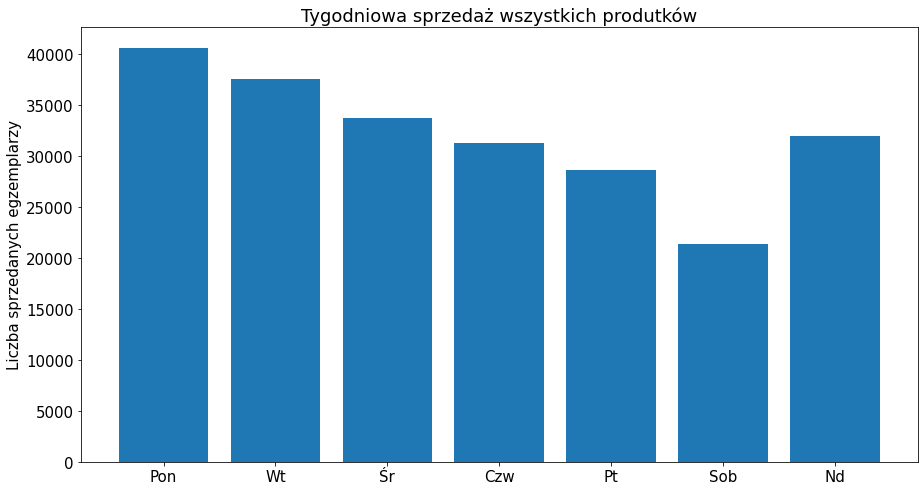

In [236]:
df1prod = df.groupby(df["Data"].dt.weekday)
df1prod = df1prod["Ilość"].sum().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()

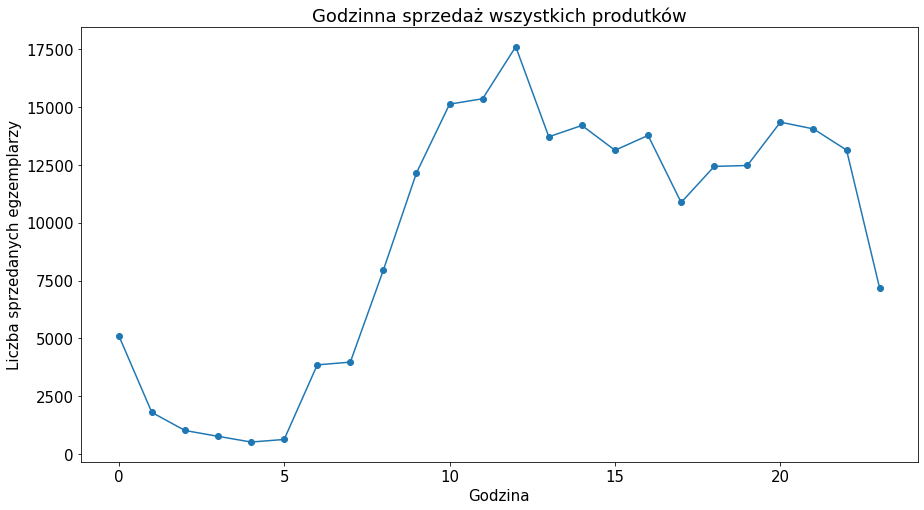

In [257]:
df1prod = df.groupby(df["Data"].dt.hour)
df1prod = df1prod["Ilość"].sum().reindex(range(0,24), fill_value = 0)
df1prod.plot(marker="o")
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.xlabel("Godzina")
plt.title(f"Godzinna sprzedaż wszystkich produtków")
plt.show()

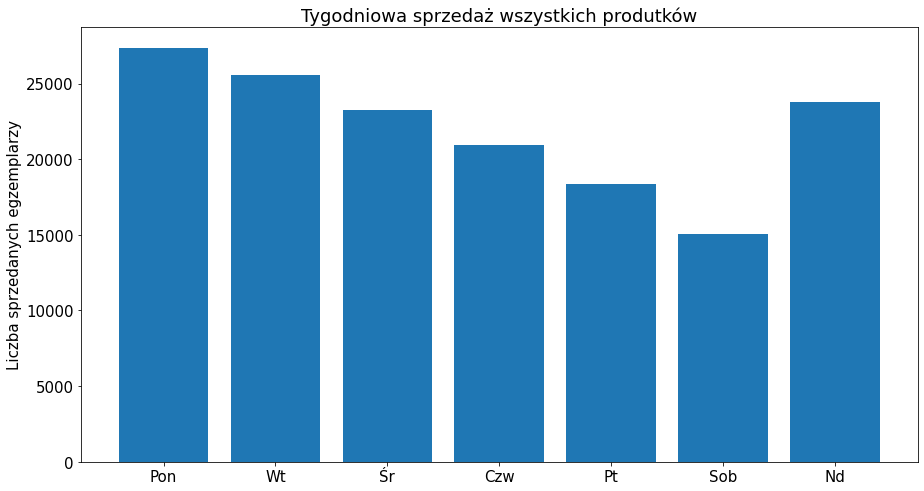

In [246]:
df1prod = df.groupby(df["Data"].dt.weekday)
df1prod = df1prod["ID zamówienia"].nunique().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()

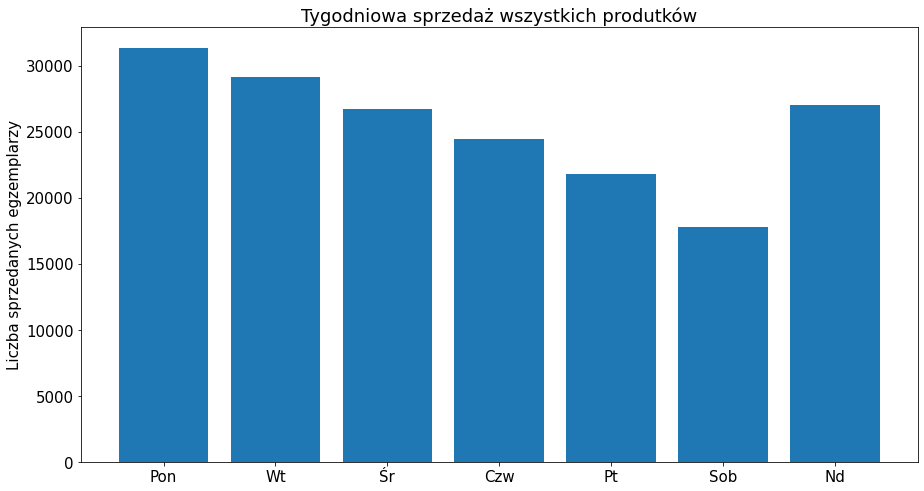

In [253]:
df1prod = df["Nazwa produktu"].groupby(df["Data"].dt.weekday).count()
# df1prod = df1prod["ID zamówienia"].nunique().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()

479.0

In [73]:
product_names

array(['shumee Strečový potah na pohovku antracitový, polyesterový žerzej',
       'shumee Sada konferenčních stolků 2 ks masivní borovice bílá ',
       'shumee Toaleta pro psy s nádobou a umělou trávou zelená 63x50x7 cm WC',
       ..., 'Lokita - 2291 M', 'Trussardi - 71B962T',
       'Cavalli Class - B0IQB62991124_C251_306 36'], dtype=object)

In [104]:
name = "Wypukłe lustro drogowe, 30 cm, czarne"

df1prod = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.weekday)
df1prod = df1prod["Ilość"].sum()

df1prod

Data
0    99.0
1    79.0
2    76.0
3    60.0
4    57.0
5    55.0
6    53.0
Name: Ilość, dtype: float64

In [150]:
print(df.iloc[1]["Data"].quarter)
# print(df[df["Data"].dt.date==date(2020,4,15)])
print(df[df["Data"].dt.date==date(2020,4,15)]["Data"].dt.quarter)

1
113199    2
113277    2
113278    2
113281    2
113285    2
         ..
113749    2
113750    2
113752    2
113753    2
113754    2
Name: Data, Length: 464, dtype: int64
